<a href="https://colab.research.google.com/github/AnirudhMehta/code_snippets/blob/master/Assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

                 T (years)    B(0,T)    D(0,T)         r         q  \
Expiration Date                                                      
2022-03-09        0.002740  0.999963  0.997493  0.013435  0.916033   
2022-03-11        0.008219  1.000078  0.997461 -0.009507  0.309278   
2022-03-14        0.016438  1.000149  0.997262 -0.009087  0.166791   
2022-03-16        0.021918  0.999846  0.997029  0.007009  0.135747   
2022-03-18        0.027397  0.999927  0.996945  0.002662  0.111696   
2022-03-21        0.035616  1.000221  0.997250 -0.006207  0.077311   
2022-03-23        0.041096  1.000345  0.997326 -0.008392  0.065158   
2022-03-25        0.046575  0.999866  0.996831  0.002875  0.068158   
2022-03-28        0.054795  0.999968  0.996912  0.000582  0.056451   
2022-03-30        0.060274  1.000062  0.996951 -0.001026  0.050661   
2022-03-31        0.063014  1.000010  0.996890 -0.000151  0.049438   
2022-04-01        0.065753  1.000075  0.996909 -0.001141  0.047080   
2022-04-04        0.

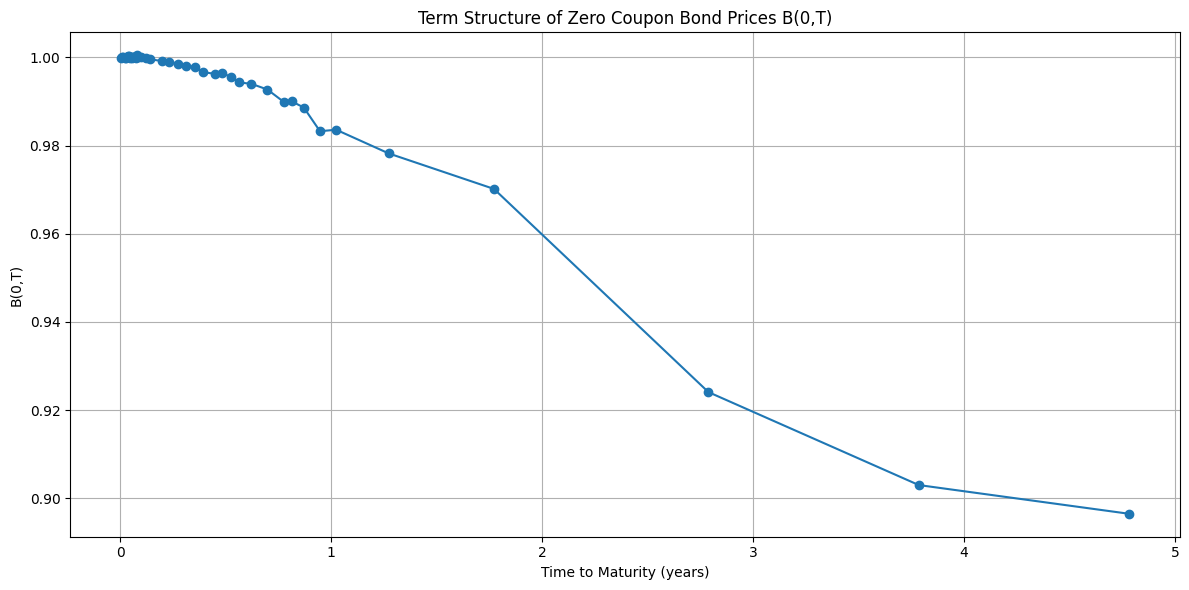

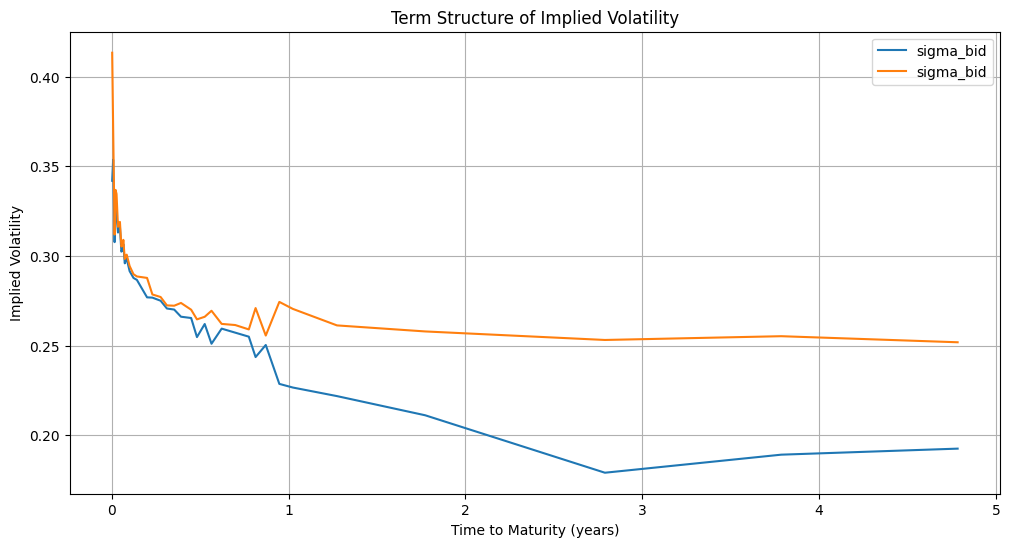

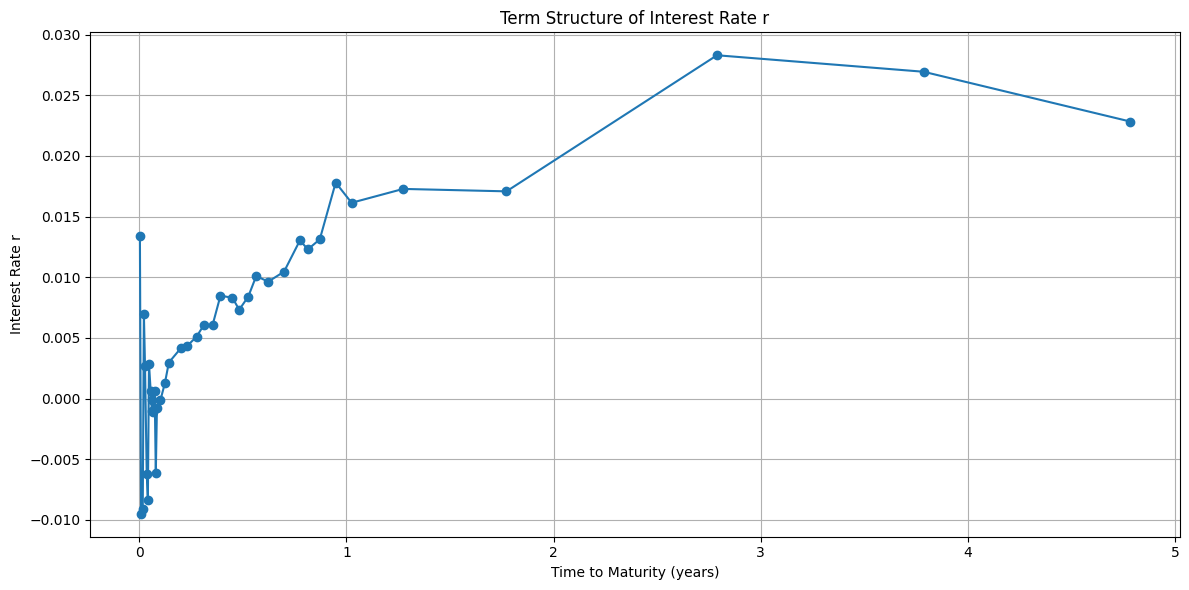

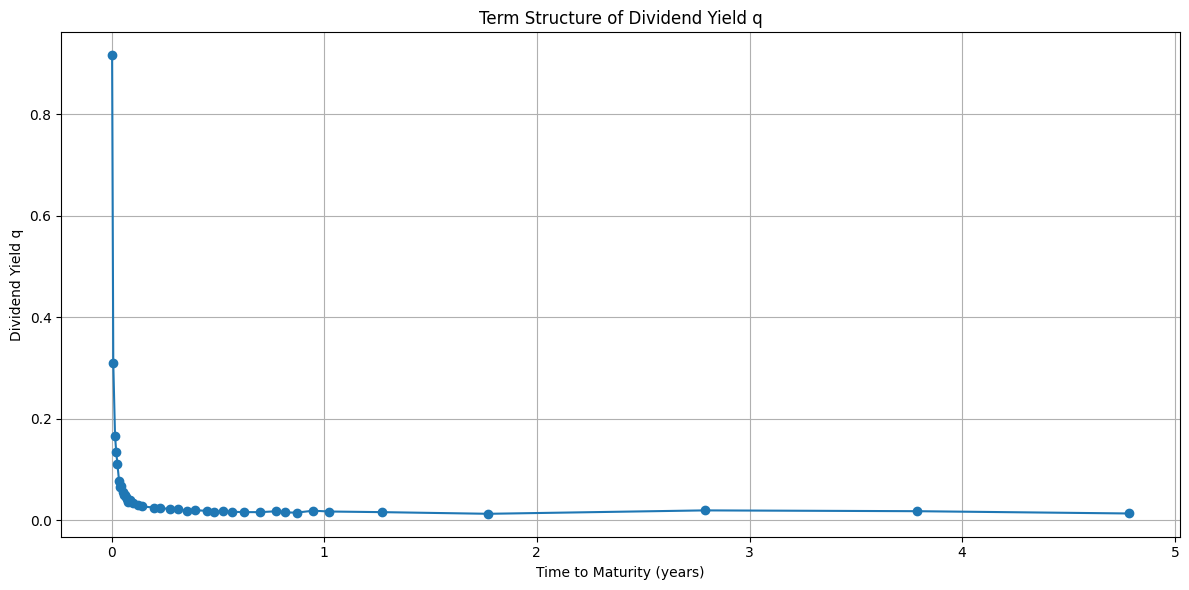

In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize, root_scalar
from scipy.stats import norm
from datetime import datetime
import matplotlib.pyplot as plt

# Constants
S0 = 4170.7002  # Initial index level
T0 = datetime(2022, 3, 8)  # Assuming T0 is March 8, 2022
file_path = "spx_quotedata20220308_all.xlsx"


# Helper functions
def objective(x, K, C, P, S0):
    B, D = x
    return np.sum((C - P - D * S0 + B * K) ** 2)


def extract_r_and_q(B, D, T):
    r = -np.log(B)/T
    q = -np.log(D)/T
    return r, q


def black_scholes(S, K, sigma, r, q, T, option_type):
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type == 'call':
        return S * np.exp(-q * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * np.exp(-q * T) * norm.cdf(-d1)


def black_scholes_imp_vol(S, K, r, q, T, option_type, market_price):
    def objective_function(sigma):
        model_price = black_scholes(S, K, sigma, r, q, T, option_type)
        return model_price - market_price

    sol = root_scalar(objective_function, bracket=[0.00001, 5], method='brentq')
    return sol.root


# Load and prepare data
def load_data(file_path):
    df = pd.read_excel(file_path)
    df['Call_Mid'] = (df['Bid'] + df['Ask']) / 2
    df['Put_Mid'] = (df['Bid.1'] + df['Ask.1']) / 2
    return df


# Main analysis function
def analyze_options_data(df):
    results_list = []

    for date_str in df['Expiration Date'].unique():
        data = df[df['Expiration Date'] == date_str]
        expiry_date = pd.to_datetime(date_str)
        T = (expiry_date - T0).days / 365

        # Optimize for B and D
        x0 = [0.99, 1.0]  # Initial guess for B and D
        res = minimize(objective, x0, args=(data['Strike'], data['Call_Mid'], data['Put_Mid'], S0),
                       method='L-BFGS-B', options={'gtol': 1e-8, 'disp': False})
        B, D = res.x
        r, q = extract_r_and_q(B, D, T)

        # Calculate forward price and find closest strike
        forward_price = S0 * D / B
        closest_strike = data.loc[(data['Strike'] - forward_price).abs().idxmin(), 'Strike']

        # Calculate implied volatilities
        call_bid = data.loc[data['Strike'] == closest_strike, 'Bid'].values[0]
        call_ask = data.loc[data['Strike'] == closest_strike, 'Ask'].values[0]
        sigma_bid = black_scholes_imp_vol(S0, closest_strike, r, q, T, 'call', call_bid)
        sigma_ask = black_scholes_imp_vol(S0, closest_strike, r, q, T, 'call', call_ask)

        results_list.append({
            'Expiration Date': expiry_date,
            'T (years)': T,
            'B(0,T)': B,
            'D(0,T)': D,
            'r': r,
            'q': q,
            'Forward Price': forward_price,
            'Closest Strike': closest_strike,
            'sigma_bid': sigma_bid,
            'sigma_ask': sigma_ask
        })

    return pd.DataFrame(results_list).set_index('Expiration Date').sort_index()


# Plotting functions
def plot_zero_coupon_bond_prices(results_df):
    plt.figure(figsize=(12, 6))
    plt.plot(results_df['T (years)'], results_df['B(0,T)'], marker='o')
    plt.title('Term Structure of Zero Coupon Bond Prices B(0,T)')
    plt.xlabel('Time to Maturity (years)')
    plt.ylabel('B(0,T)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_implied_volatility(results_df):
    plt.figure(figsize=(12, 6))
    plt.plot(results_df['T (years)'], results_df['sigma_bid'], label='sigma_bid')
    plt.plot(results_df['T (years)'], results_df['sigma_ask'], label='sigma_bid')
    plt.title('Term Structure of Implied Volatility')
    plt.xlabel('Time to Maturity (years)')
    plt.ylabel('Implied Volatility')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_interest_rate(results_df):
    plt.figure(figsize=(12, 6))
    plt.plot(results_df['T (years)'], results_df['r'], marker='o')
    plt.title('Term Structure of Interest Rate r')
    plt.xlabel('Time to Maturity (years)')
    plt.ylabel('Interest Rate r')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_dividend_yield(results_df):
    plt.figure(figsize=(12, 6))
    plt.plot(results_df['T (years)'], results_df['q'], marker='o')
    plt.title('Term Structure of Dividend Yield q')
    plt.xlabel('Time to Maturity (years)')
    plt.ylabel('Dividend Yield q')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
# Main execution
if __name__ == "__main__":
    df = load_data(file_path)
    results_df = analyze_options_data(df)
    pd.set_option('display.max_columns', None)
    print(results_df)

    plot_zero_coupon_bond_prices(results_df)
    plot_implied_volatility(results_df)
    plot_interest_rate(results_df)
    plot_dividend_yield(results_df)